In [1]:
import rdflib
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx

from knowledge_graph import *
from rdf2vec import RDF2VecTransformer
from LCS import new_lcs
from rdf_graph_utils import rdf_to_plot, rdf_to_text

In [2]:
#print(end='Loading data... ', flush=True)
#g = rdflib.Graph()
#g.parse('data/prova.nt', format="nt")
#print('OK')

#rdf_to_plot(g)

In [ ]:
# URI DI TUTTE LE DRUGS
all_drugs_file = pd.read_csv('data/all_drugs.tsv', sep='\t')
all_drugs = [rdflib.URIRef(x) for x in all_drugs_file['drug']]

# PREDICATI DA ESCLUDERE NELL'ESTRAZIONE DEL GRAFO
predicates = pd.read_csv('data/bad_predicates.tsv', sep='\t')
predicates = [rdflib.URIRef(x) for x in predicates['predicate']]

# ESTRAZIONE DI UNINFORMATIVE TRIPLES E STOPPING PATTERNS DAI FILE
preds = pd.read_csv('data/uninformative.tsv', sep='\t')
preds = [rdflib.URIRef(x) for x in preds['uninformative']]

stop_patterns = pd.read_csv('data/stop_patterns.tsv', sep='\t')
stop_patterns = [x for x in stop_patterns['stopping_patterns']]

In [3]:
print(end='Loading data... ', flush=True)
g = rdflib.Graph()
#g.parse('data/new_limit_500k.nt', format="nt")

g.parse('data/drugbank_nt.nt', format="nt")
print('OK')

Loading data... OK


In [4]:
# TRASFORMAZIONE DELL'INTERO GRAFO IN KNOWLEDGE GRAPH (contenente matrice di adiacenze, necessario per rdf2vec)
kg = rdflib_to_kg(g, label_predicates=predicates)

In [124]:
# PER OGNI DRUG VIENE ESTRATTO IL SUB-GRAPH SE PRESENTE NELLA NOSTRO KB
i = 1
j = 1

kv = []
drugs = []
graphs = []
for drug in all_drugs:
    try:
        g = extract_instance(kg, drug, 4)
        graphs.append(g)
        drugs.append(drug)
        kv.append( {'graph': g, 'resource': drug} )
        i += 1
    except Exception as e:
        j += 1
        
print('ok:' + str(i))

ok:7671


In [37]:
for d in drugs:
    if d == rdflib.term.URIRef("http://bio2rdf.org/drugbank:DB00407"):
        print("ardeparin: " + str(drugs.index(d)))

ardeparin: 183


In [38]:
for d in drugs:
    if d == rdflib.term.URIRef("http://bio2rdf.org/drugbank:DB01109"):
        print("heparin: " + str(drugs.index(d)))

heparin: 1863


In [ ]:
# ESTRAZIONE DEGLI EMBEDDINGS TRAMITE RDF2VEC E CLUSTERING
# Embeddings
transformer = RDF2VecTransformer(_type='walk', vector_size=200, walks_per_graph=500)
embeddings = transformer.fit_transform(graphs)

In [128]:
print(embeddings[0])
print(drugs[0])

[-0.13579929  0.10634991 -0.19508587  0.13740389  0.38226447  0.0082841
 -0.18999708  0.07511245 -0.05183074 -0.2520642  -0.0540712  -0.15153484
 -0.04447071 -0.16060801  0.05534524  0.1488969  -0.27106872  0.3042951
 -0.05097584 -0.05965914 -0.44421697 -0.25543192 -0.08128304  0.09806249
 -0.2019982   0.20640387  0.23951831 -0.01821028  0.38302115  0.05290831
  0.20518596  0.17835723  0.08116619  0.02235514 -0.25621486 -0.11301162
 -0.30324066 -0.11542427  0.0052605   0.03931064  0.07225893  0.38304454
  0.08830022 -0.0689913  -0.17660433  0.06619848  0.24241337  0.27934432
 -0.5490026   0.0085024  -0.18012963 -0.06430514  0.5124184   0.1760997
 -0.01199443 -0.23589316 -0.2917533   0.25213343 -0.13965419  0.16451903
  0.36159495 -0.10520194  0.04550585 -0.3518131   0.04775634  0.1455451
  0.08535515 -0.19351435 -0.07632845 -0.1885232  -0.06593035 -0.36776882
 -0.11818709 -0.13130622  0.17677292  0.21360831  0.13164225 -0.10057025
  0.22856802 -0.25652778  0.01541908  0.19481231 -0.011

In [123]:
# CLUSTERING K-MEANS CON 7 CLUSTER
kmeans = KMeans(n_clusters=7)
k = kmeans.fit(embeddings)
y_kmeans = kmeans.predict(embeddings)

In [121]:
# STAMPO PER OGNI RISORSA IL CLUSTER A CUI CORRISPONDE, IN MODO DA POTERNE PRELEVARE PER IL MOMENTO
# DUE APPARTENENTI ALLO STESSO CLUSTER
k = 0
for y in y_kmeans:
    print(str(k) + ': ' + str(y))
    k += 1

0: 3
1: 3
2: 3
3: 6
4: 2
5: 3
6: 3
7: 5
8: 3
9: 3
10: 3
11: 5
12: 3
13: 3
14: 3
15: 3
16: 2
17: 2
18: 2
19: 2
20: 2
21: 3
22: 1
23: 1
24: 2
25: 1
26: 2
27: 0
28: 2
29: 2
30: 5
31: 0
32: 5
33: 2
34: 5
35: 5
36: 2
37: 0
38: 1
39: 0
40: 2
41: 1
42: 2
43: 1
44: 2
45: 2
46: 2
47: 5
48: 6
49: 2
50: 6
51: 6
52: 6
53: 1
54: 1
55: 3
56: 6
57: 1
58: 1
59: 3
60: 6
61: 1
62: 2
63: 1
64: 6
65: 1
66: 1
67: 6
68: 1
69: 1
70: 6
71: 1
72: 3
73: 1
74: 1
75: 2
76: 1
77: 6
78: 1
79: 1
80: 1
81: 1
82: 6
83: 1
84: 1
85: 1
86: 1
87: 1
88: 3
89: 2
90: 1
91: 6
92: 1
93: 1
94: 4
95: 6
96: 6
97: 6
98: 6
99: 1
100: 3
101: 6
102: 6
103: 6
104: 1
105: 1
106: 1
107: 3
108: 1
109: 5
110: 5
111: 3
112: 3
113: 2
114: 3
115: 2
116: 0
117: 1
118: 3
119: 3
120: 2
121: 4
122: 6
123: 3
124: 2
125: 2
126: 2
127: 1
128: 2
129: 2
130: 1
131: 1
132: 2
133: 2
134: 5
135: 1
136: 2
137: 1
138: 2
139: 2
140: 2
141: 2
142: 2
143: 2
144: 5
145: 2
146: 2
147: 2
148: 3
149: 2
150: 2
151: 2
152: 2
153: 2
154: 2
155: 6
156: 6
157: 1
158:

1970: 1
1971: 1
1972: 1
1973: 1
1974: 6
1975: 1
1976: 3
1977: 6
1978: 1
1979: 6
1980: 2
1981: 6
1982: 2
1983: 3
1984: 2
1985: 2
1986: 3
1987: 1
1988: 2
1989: 2
1990: 6
1991: 2
1992: 5
1993: 3
1994: 6
1995: 2
1996: 6
1997: 6
1998: 6
1999: 2
2000: 3
2001: 3
2002: 3
2003: 3
2004: 3
2005: 6
2006: 3
2007: 1
2008: 4
2009: 6
2010: 1
2011: 5
2012: 5
2013: 1
2014: 2
2015: 2
2016: 6
2017: 5
2018: 1
2019: 3
2020: 5
2021: 2
2022: 5
2023: 6
2024: 2
2025: 6
2026: 2
2027: 6
2028: 2
2029: 3
2030: 3
2031: 3
2032: 1
2033: 3
2034: 6
2035: 2
2036: 3
2037: 1
2038: 2
2039: 2
2040: 2
2041: 3
2042: 6
2043: 3
2044: 1
2045: 1
2046: 1
2047: 1
2048: 2
2049: 2
2050: 1
2051: 2
2052: 3
2053: 1
2054: 1
2055: 6
2056: 1
2057: 1
2058: 6
2059: 5
2060: 1
2061: 6
2062: 1
2063: 6
2064: 1
2065: 6
2066: 1
2067: 1
2068: 6
2069: 6
2070: 6
2071: 6
2072: 6
2073: 1
2074: 1
2075: 2
2076: 1
2077: 6
2078: 1
2079: 6
2080: 6
2081: 6
2082: 6
2083: 6
2084: 1
2085: 3
2086: 1
2087: 6
2088: 1
2089: 6
2090: 6
2091: 1
2092: 2
2093: 6
2094: 6


3469: 2
3470: 5
3471: 4
3472: 4
3473: 4
3474: 4
3475: 3
3476: 3
3477: 4
3478: 4
3479: 5
3480: 5
3481: 0
3482: 4
3483: 0
3484: 5
3485: 3
3486: 0
3487: 3
3488: 0
3489: 4
3490: 4
3491: 5
3492: 5
3493: 5
3494: 5
3495: 5
3496: 2
3497: 4
3498: 3
3499: 4
3500: 3
3501: 5
3502: 0
3503: 4
3504: 0
3505: 5
3506: 4
3507: 4
3508: 5
3509: 5
3510: 4
3511: 4
3512: 0
3513: 4
3514: 4
3515: 3
3516: 3
3517: 4
3518: 4
3519: 3
3520: 0
3521: 4
3522: 3
3523: 5
3524: 3
3525: 0
3526: 5
3527: 3
3528: 4
3529: 5
3530: 2
3531: 3
3532: 4
3533: 5
3534: 4
3535: 5
3536: 0
3537: 4
3538: 4
3539: 4
3540: 4
3541: 4
3542: 3
3543: 4
3544: 3
3545: 0
3546: 5
3547: 3
3548: 4
3549: 0
3550: 4
3551: 5
3552: 4
3553: 4
3554: 0
3555: 5
3556: 3
3557: 5
3558: 5
3559: 0
3560: 3
3561: 4
3562: 2
3563: 5
3564: 3
3565: 4
3566: 4
3567: 5
3568: 4
3569: 4
3570: 2
3571: 3
3572: 4
3573: 0
3574: 5
3575: 5
3576: 0
3577: 4
3578: 4
3579: 5
3580: 0
3581: 5
3582: 5
3583: 5
3584: 3
3585: 4
3586: 0
3587: 5
3588: 4
3589: 3
3590: 4
3591: 3
3592: 4
3593: 3


5198: 4
5199: 5
5200: 0
5201: 4
5202: 0
5203: 5
5204: 5
5205: 5
5206: 5
5207: 5
5208: 5
5209: 5
5210: 3
5211: 4
5212: 0
5213: 4
5214: 3
5215: 5
5216: 5
5217: 4
5218: 5
5219: 3
5220: 4
5221: 5
5222: 3
5223: 0
5224: 5
5225: 5
5226: 5
5227: 5
5228: 5
5229: 4
5230: 5
5231: 0
5232: 0
5233: 5
5234: 5
5235: 5
5236: 5
5237: 5
5238: 4
5239: 0
5240: 5
5241: 4
5242: 3
5243: 5
5244: 5
5245: 5
5246: 5
5247: 5
5248: 0
5249: 5
5250: 5
5251: 0
5252: 5
5253: 4
5254: 5
5255: 0
5256: 4
5257: 4
5258: 5
5259: 4
5260: 0
5261: 5
5262: 4
5263: 5
5264: 5
5265: 5
5266: 0
5267: 4
5268: 5
5269: 5
5270: 5
5271: 5
5272: 4
5273: 4
5274: 5
5275: 4
5276: 5
5277: 4
5278: 5
5279: 5
5280: 5
5281: 4
5282: 0
5283: 0
5284: 4
5285: 0
5286: 0
5287: 0
5288: 0
5289: 0
5290: 0
5291: 3
5292: 0
5293: 2
5294: 4
5295: 5
5296: 4
5297: 5
5298: 5
5299: 5
5300: 5
5301: 5
5302: 5
5303: 5
5304: 4
5305: 5
5306: 3
5307: 1
5308: 1
5309: 3
5310: 3
5311: 1
5312: 1
5313: 1
5314: 1
5315: 6
5316: 6
5317: 1
5318: 1
5319: 6
5320: 2
5321: 1
5322: 2


6968: 3
6969: 0
6970: 0
6971: 0
6972: 4
6973: 0
6974: 0
6975: 0
6976: 0
6977: 0
6978: 0
6979: 0
6980: 0
6981: 0
6982: 0
6983: 0
6984: 5
6985: 4
6986: 4
6987: 4
6988: 5
6989: 0
6990: 0
6991: 0
6992: 0
6993: 5
6994: 5
6995: 4
6996: 5
6997: 5
6998: 5
6999: 4
7000: 5
7001: 4
7002: 4
7003: 0
7004: 0
7005: 5
7006: 5
7007: 0
7008: 5
7009: 5
7010: 5
7011: 5
7012: 4
7013: 5
7014: 5
7015: 5
7016: 5
7017: 2
7018: 4
7019: 0
7020: 2
7021: 0
7022: 4
7023: 0
7024: 0
7025: 5
7026: 4
7027: 5
7028: 5
7029: 4
7030: 2
7031: 3
7032: 0
7033: 4
7034: 5
7035: 5
7036: 4
7037: 5
7038: 0
7039: 4
7040: 2
7041: 2
7042: 5
7043: 0
7044: 4
7045: 3
7046: 3
7047: 3
7048: 0
7049: 4
7050: 0
7051: 4
7052: 4
7053: 5
7054: 0
7055: 4
7056: 4
7057: 5
7058: 0
7059: 0
7060: 5
7061: 5
7062: 4
7063: 3
7064: 2
7065: 4
7066: 4
7067: 2
7068: 5
7069: 0
7070: 4
7071: 5
7072: 0
7073: 0
7074: 0
7075: 0
7076: 5
7077: 0
7078: 0
7079: 0
7080: 0
7081: 5
7082: 0
7083: 4
7084: 0
7085: 0
7086: 0
7087: 4
7088: 0
7089: 5
7090: 4
7091: 4
7092: 5


In [125]:
# SELEZIONO I GRAFI RELATIVI A DUE DRUGS RISULTANTI NELLO STESSO CLUSTER
drug1 = drugs[48]
drug2 = drugs[50]

graph1 = graphs[48]
graph2 = graphs[50]

print(drug1)
#graph1.visualise()
print(drug2)
#graph2.visualise()


http://bio2rdf.org/drugbank:DB00182
http://bio2rdf.org/drugbank:DB00191


In [126]:
# CREAZIONE DEL GRAFO OTTENUTO DAL LCS
rdflib_x_Tx = new_lcs(graph1, graph2, depth=2, stop_patterns=stop_patterns, uninformative_triples=preds)


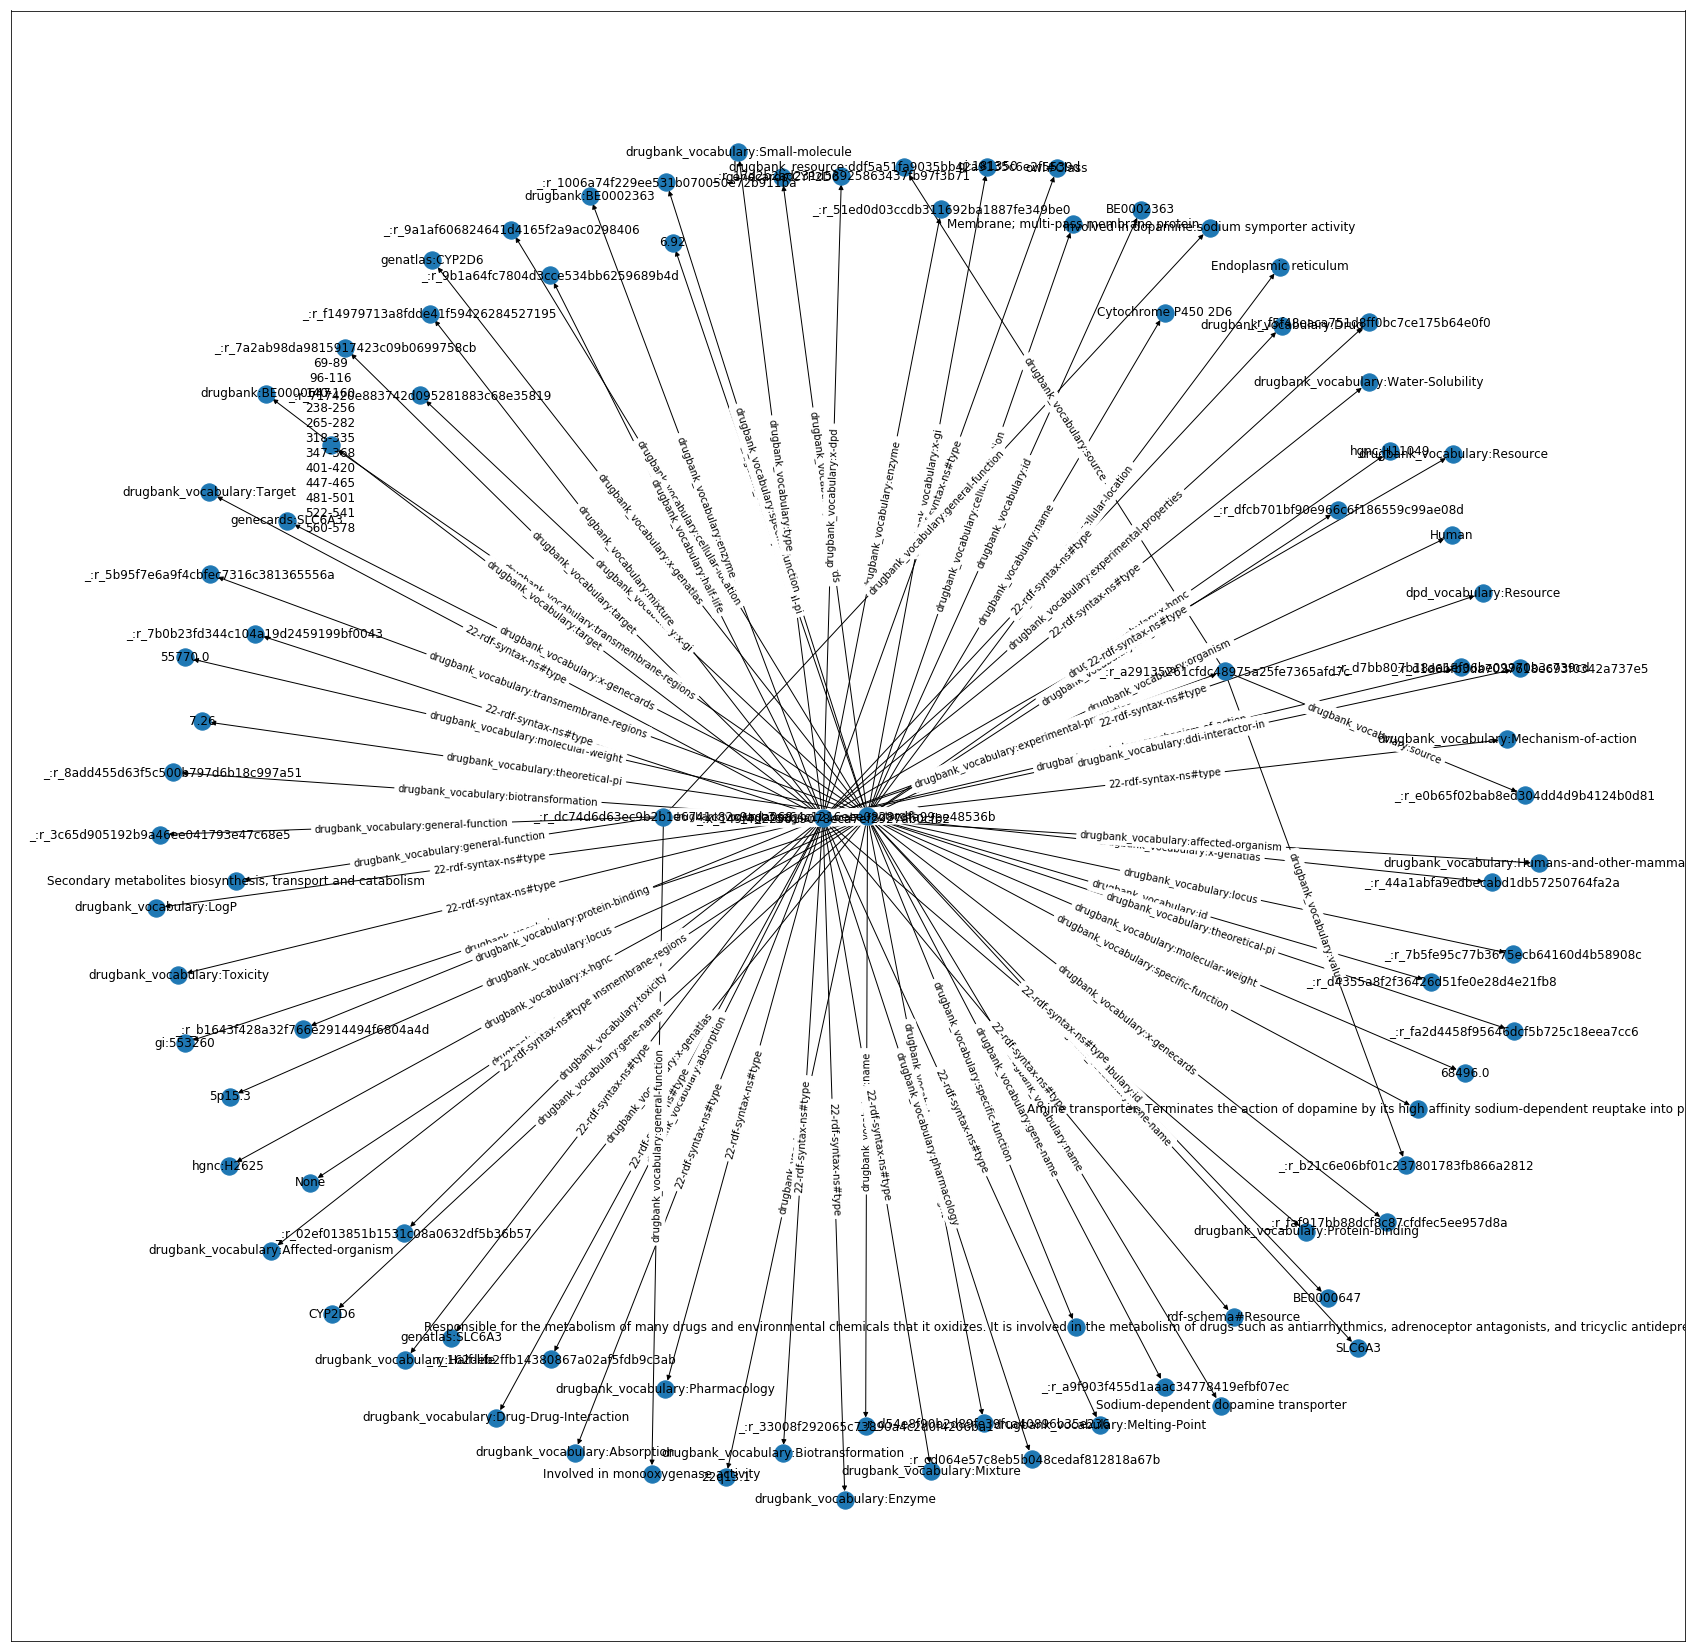

b'"_:r_c3ce64c1216eee0828cdfa99ee48536b" <http://bio2rdf.org/drugbank_vocabulary:x-gi> <http://bio2rdf.org/gi:181350> .\n"_:x_149f4d225019078eca7ef2927ab0cfb2" <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://bio2rdf.org/drugbank_vocabulary:Mixture> .\n"_:r_a29135261cfdc48975a25fe7365afd7c" <http://bio2rdf.org/drugbank_vocabulary:source> <http://bio2rdf.org/drugbank_resource:ddf5a51fa9035bb42a9135c6e2f5539d> .\n"_:x_149f4d225019078eca7ef2927ab0cfb2" <http://bio2rdf.org/drugbank_vocabulary:mixture> "_:r_f14979713a8fdde41f59426284527195" .\n"_:x_149f4d225019078eca7ef2927ab0cfb2" <http://bio2rdf.org/drugbank_vocabulary:enzyme> <http://bio2rdf.org/drugbank:BE0002363> .\n"_:x_149f4d225019078eca7ef2927ab0cfb2" <http://bio2rdf.org/drugbank_vocabulary:affected-organism> <http://bio2rdf.org/drugbank_vocabulary:Humans-and-other-mammals> .\n"_:r_dc74d6d63ec9b2b1e6741c82c9ada068" <http://bio2rdf.org/drugbank_vocabulary:general-function> "Involved in monooxygenase activity" .\n"_:r_dc74d6d

/usr/local/anaconda3/envs/rdf/lib/python3.6/site-packages/rdflib/plugins/serializers/nt.py:29: UserWarning: NTSerializer does not use custom encoding.
  warnings.warn("NTSerializer does not use custom encoding.")


In [127]:
# RAPPRESENTAZIONE GRAFICA IN PLOT DEL GRAFO
rdf_to_plot(rdflib_x_Tx)

# SALVATAGGIO DEL GRAFO IN FORMATO 'NT'
rdf_to_text(rdflib_x_Tx, 'data/outputs', 'nt')

In [ ]:
# ESTRAZIONE DELLE COMPONENTI PRINCIPALI PER POTER RAPPRESENTARE GRAFICAMENTE LA DISTINZIONE IN CLUSTER 
# 2 PC -> RAPPRESENTAZIONE 2D
# 3 PC -> RAPPRESENTAZIONE 3D

# PCA (2)
pca = PCA(n_components=2)
pca = pca.fit_transform(embeddings)

principalDf = pd.DataFrame(data=pca, columns=['pc1', 'pc2'])

In [ ]:
# KMEANS SU LE 2 PC PER POTER INDIVIDUARE I PUNTI CENTRALI PER LA RAPPRESENTAZIONE GRAFICA (STEP NON NECESSARIO)
kmeans2 = KMeans(n_clusters=7)
kmeans2.fit(principalDf)

In [ ]:
# rappresentazione grafica
plt.scatter(principalDf['pc1'], principalDf['pc2'], c=y_kmeans, s=50, cmap='viridis')

centers = np.asarray(kmeans2.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

In [ ]:
# PCA (3)
pca = PCA(n_components=3)
pca = pca.fit_transform(embeddings)

principalDf = pd.DataFrame(data=pca, columns=['pc1', 'pc2', 'pc3'])

kmeans2 = KMeans(n_clusters=7)
kmeans2.fit(principalDf)

In [ ]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(principalDf['pc1'], principalDf['pc2'], principalDf['pc3'], c=y_kmeans, s=50, cmap='viridis')

centers = np.asarray(kmeans2.cluster_centers_)
ax.scatter(centers[:,0], centers[:,1], centers[:,2], c='black', s=200, alpha=0.5)